In [1]:
#Source of this work : https://www.kaggle.com/code/arnavr10880/vgg16-vs-mobilenetv2-who-wins

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/Rice_Image_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Suneel\Anaconda\envs\modelling\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Suneel\Anaconda\envs\modelling\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Suneel\Anaconda\envs\modelling\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Image Classification

Image classification is done by taking the help of Convolutional Neural Network (CNN) which try to detect different features (edges, lines initially and then their combinations later in their depth) from the images that are passed to them. The image is passed through different layers of filters. As the image is passed to the subsequent deep layers, more complicated features are extracted and identified.

# Models used

The models that are used in this notebook are:

- VGG16
- MobileNetV2

The above models are used here to perform transfer learning on our dataset.

### What is transfer learning?

Transfer learning is a problem in machine learning in which we try to use the knowledge that we gained by solving one problem on different but related problem.

<center><img height=700 width=700 src='https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png'></img></center>



# About Data

This dataset is aimed towards classifying 7 classes: Barhee, Deglet Nour, Sukkary, Rotab Mozafati, Ruthana, Safawi, Sagai using Machine Learning methods.

# Setting up the data

The data that we have is distributed in two folders:
- **Arborio**
- **Basmati**
- **Ipsala**
- **Jasmine**
- **Karacadag**

But to start, we will be needing 3 folders:
- **Training folder**: on which the model will be trained
- **Validation folder**: on which we will assess the accuracy of our Neural Network model
- **Testing folder**: which can be used for final testing. The model will see this dataset only once.

To split our folders into the above 3 sets, we can automate this task using a python library called **split-folders**.

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Suneel\Anaconda\envs\modelling\python.exe -m pip install --upgrade pip' command.


In [4]:
import splitfolders

# first we specify the folder directory that we want to split
# then we specify the output folder
# and we provide the ratio of split (here 70% for training, 20% for validation and 10% for testing)
splitfolders.ratio('./Rice_Image_Dataset', output="data", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 75000 files [02:20, 533.50 files/s] 


Now, as the directory has been created, we can easily work on it.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [11]:
# setting the size to this
IMAGE_SIZE = (224, 224)

train_path = './data/train'
val_path = './data/val'
test_path = './data/test'

The neural networks work best when the images are normalized/standardized.

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)

eval_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_batch = train_datagen.flow_from_directory('./data/train',
                                                 target_size = (224, 224), # should be same as the initialized one
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

val_batch = eval_datagen.flow_from_directory('./data/val',
                                                 target_size = (224, 224),
                                                 batch_size = 20,
                                                 class_mode = 'categorical')

test_batch = test_datagen.flow_from_directory('./data/test',
                                                 target_size = (224, 224),
                                                 batch_size = 30,
                                                 class_mode = 'categorical')

Found 52500 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


# About ImageNet

Imagenet is a defacto standard for images classification. 

- The ImageNet is a pre-trained network inside Keras which is capable of classifying 1000 different object categories with high accuracy. 

- Therefore it provides a "standard" measure for how good a model is for image classification. So many often transfer learning models use the imagenet weights.

# VGG16

The model architecture: (It is 16 layers deep, hence the name VGG16)

<center><img src='https://raw.githubusercontent.com/moelgendy/deep_learning_for_vision_systems/2c9d077b43003657cd8f6d5ddfb6f83ee8bae1f3/chapter_05/images/vggnet_architecture.png'></img></center>

We will set our own top and last layer of the model, hence we do `include_top=False`.

In [14]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [15]:
for layer in vgg.layers:
    layer.trainable = False # we dont train the existing weights

In [16]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Output Layer

We flatten the data to convert into 1-dimensional array for imputing it to the next layer. Flattening creates a single long feature vector and is connected to the final classification model.

<center><img src='https://miro.medium.com/max/1400/1*IWUxuBpqn2VuV-7Ubr01ng.png'></img></center>

In [17]:
# we create our own last layers

last_output = vgg.output

norm = BatchNormalization()(last_output)
x = Dropout(0.5)(norm)

flat = Flatten()(x) # Flattening the output from the previous layer
pred = Dense(5, activation='softmax', name='softmax')(flat) # we have 2 possibilites: Positive or Negative

new_model = Model(inputs=vgg.input, outputs=pred) # concatenates the layers

In [18]:
# top layers of the network
new_model.layers[-5:-1]

After creating the network, we need to compile it before fitting it to the dataset. We provide the following arguments in the compile function:
- **Optimizer**: to tune the parameters of a neural network. Adam is chosen here because for most of the cases it is a perfect one.
- **Loss**: to calculate loss. It can be:
    - **Binary Crossentrop**y: for binary classification
    - **Categorical Crossentropy**: for multi-class classification. The output is one hot-encoded (i.e. 0's , 1's).
    - **Sparse Categorical Crossentropy**: for multi-class classification. The output is integral (i.e 1, 2, 3).
- **Metrics**: the metric to assess the accuracy.

Then, we compile the model.

In [19]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
 metrics=['accuracy'])

An epoch indicates the number of times the model sees the same batch of data again.

In [20]:
start_time = time.perf_counter()

hist1 = new_model.fit(train_batch, steps_per_epoch=18,
             validation_data=val_batch, validation_steps=3, epochs=5,
             verbose=1)

time1 = round(time.perf_counter() - start_time, 2)
print (f'\n\nTime taken by VGG16: {time1} seconds')

Epoch 1/5
18/18 [==============================] - 16s 894ms/step - loss: 2.1043 - accuracy: 0.2851 - val_loss: 1.4937 - val_accuracy: 0.4667
Epoch 2/5
18/18 [==============================] - 17s 979ms/step - loss: 1.0050 - accuracy: 0.5960 - val_loss: 1.2346 - val_accuracy: 0.5833
Epoch 3/5
18/18 [==============================] - 18s 1s/step - loss: 0.5752 - accuracy: 0.7729 - val_loss: 1.2089 - val_accuracy: 0.5333
Epoch 4/5
18/18 [==============================] - 19s 1s/step - loss: 0.5974 - accuracy: 0.7824 - val_loss: 1.0018 - val_accuracy: 0.5833
Epoch 5/5
18/18 [==============================] - 18s 1s/step - loss: 0.4340 - accuracy: 0.8611 - val_loss: 0.9569 - val_accuracy: 0.6167


Time taken by VGG16: 88.48 seconds


# MobileNetV2

The same procedure is followed here.

<center><img src='https://www.researchgate.net/publication/337970110/figure/fig3/AS:836949766045697@1576555782961/MobileNetV2-6-uses-a-3-3-convolution-for-the-depth-wise-phase-of-the-convolution-and.jpg'></img></center>

In [21]:
mnv = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [22]:
for layer in mnv.layers:
    layer.trainable = False

In [23]:
mnv.summary() 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [24]:
last_output = mnv.output

x = Flatten()(last_output)
pred = Dense(5, activation='softmax', name='softmax')(x)

new_model = Model(inputs=mnv.input, outputs=pred)

In [25]:
new_model.layers[-5:-1]

In [26]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
 metrics=['accuracy'])

In [27]:
start_time = time.perf_counter()

hist2 = new_model.fit(train_batch, steps_per_epoch=18,
             validation_data=val_batch, validation_steps=3, epochs=5,
             verbose=1)

time2 = round(time.perf_counter() - start_time, 2)
print (f'\n\nTime taken by MobileNetV2: {time2} seconds')


Epoch 1/5
18/18 [==============================] - 6s 277ms/step - loss: 1.2353 - accuracy: 0.5158 - val_loss: 0.3106 - val_accuracy: 0.8833
Epoch 2/5
18/18 [==============================] - 4s 244ms/step - loss: 0.2688 - accuracy: 0.8658 - val_loss: 0.2292 - val_accuracy: 0.9333
Epoch 3/5
18/18 [==============================] - 5s 257ms/step - loss: 0.2065 - accuracy: 0.9462 - val_loss: 0.1803 - val_accuracy: 0.9333
Epoch 4/5
18/18 [==============================] - 4s 240ms/step - loss: 0.2100 - accuracy: 0.8924 - val_loss: 0.1657 - val_accuracy: 0.9833
Epoch 5/5
18/18 [==============================] - 4s 228ms/step - loss: 0.1153 - accuracy: 0.9540 - val_loss: 0.1879 - val_accuracy: 0.9167


Time taken by MobileNetV2: 23.62 seconds


# Accuracy Comparison

The accuracy and loss of the two models can be summarized below in the form of a plot.

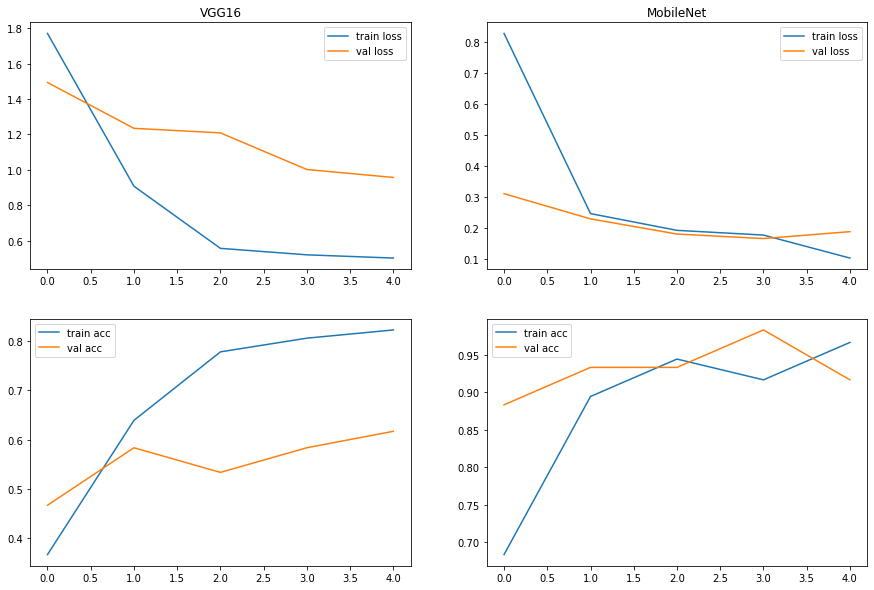

In [28]:
fig, axs = plt.subplots(2, 2, figsize=[15, 10])

axs[0,0].plot(hist1.history['loss'], label='train loss')
axs[0,0].plot(hist1.history['val_loss'], label='val loss')
axs[0,0].set_title('VGG16')
axs[0,0].legend()

axs[1,0].plot(hist1.history['accuracy'], label='train acc')
axs[1,0].plot(hist1.history['val_accuracy'], label='val acc')
axs[1,0].legend()


axs[0,1].plot(hist2.history['loss'], label='train loss')
axs[0,1].plot(hist2.history['val_loss'], label='val loss')
axs[0,1].set_title('MobileNet')
axs[0,1].legend()

axs[1,1].plot(hist2.history['accuracy'], label='train acc')
axs[1,1].plot(hist2.history['val_accuracy'], label='val acc')
axs[1,1].legend()

# Time Comparison among VGG16 & MobileNetV2: which one is faster?

In [29]:
print(f'The time taken by VGG16 is: {time1} seconds.\n\n')
print(f'The time taken by MobileNetV2 is: {time2} seconds.\n\n')

The time taken by VGG16 is: 88.48 seconds.


The time taken by MobileNetV2 is: 23.62 seconds.




We see that by just running the models for **5 epochs**, MobileNetV2 performs better than VGG16 on this dataset. It even took least amount of time as compared to time taken by VGG16.

That's all in this notebook. I hope you like it!